In [77]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter,prep_ttbar

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib


ImportError: cannot import name 'prep_ttbar' from 'load_data_fn' (/uscms_data/d3/nswood/Notebooks/AE_Dev/load_data_fn.py)

In [115]:
import importlib
importlib.reload(AE_Stats)

<module 'AE_Stats' from '/uscms_data/d3/nswood/Notebooks/AE_Dev/AE_Stats.py'>

In [2]:
device = 'cpu'

In [3]:
n = 80

arr = torch.load('data/TTBAR/ttbar_1_greater_0_sim')
if n > 0:
    for i in range(n):
        arr = torch.vstack([arr,torch.load(f'data/TTBAR/ttbar_{int(n+2)}_greater_0_sim')])



In [76]:
arr = prep_ttbar(81)  

NameError: name 'prep_ttbar' is not defined

In [4]:
dt_1 = []
dt_2 = []
dt_3 = []

for a in arr:
    
    if a[-4].item() ==0.: 
        dt_1.append(a)
    elif a[-4].item() ==1.0: 
        dt_2.append(a)
    else:
        dt_3.append(a)
    
dt_1 = torch.vstack(dt_1).float()
dt_2 = torch.vstack(dt_2).float()   
dt_3 = torch.vstack(dt_3).float()   

In [5]:
mean = torch.mean(dt_1[:,0:48])
std = torch.std(dt_1[:,0:48])

In [6]:
dt_1[:,0:48] = ((dt_1[:,0:48]-torch.mean(dt_1[:,0:48]))/torch.std(dt_1[:,0:48])).to(device)


In [9]:
dt_outlier = []
dt_m1 = []
dt_m2 = []
dt_low = []

for d in dt_1:
    if torch.norm(d[0:48]).item() < 3:
        dt_low.append(d)
    elif torch.norm(d[0:48]).item() < 5:
        dt_m1.append(d)
    elif torch.norm(d[0:48]).item() < 10:
        dt_m2.append(d)
    else:
        dt_outlier.append(d)
        
dt_outlier = torch.vstack(dt_outlier).to(device)
dt_m1 = torch.vstack(dt_m1).to(device)
dt_m2 = torch.vstack(dt_m2).to(device)
dt_low = torch.vstack(dt_low).to(device)

In [10]:
total_test = []

for d in [dt_outlier,dt_m1,dt_m2,dt_low]:
    len_test = int(len(d)*0.15)
    total_test.append(d[-len_test:])
    
total_test = torch.vstack(total_test)

In [11]:
m_low = torch.load('models/batched_models/batch_4_models_tt_bar_norm_mean_0_var_1_sim_energy/low').to(device)
m_1 =torch.load('models/batched_models/batch_4_models_tt_bar_norm_mean_0_var_1_sim_energy/m1').to(device)
m_2 = torch.load('models/batched_models/batch_4_models_tt_bar_norm_mean_0_var_1_sim_energy/m2').to(device)
m_outlier = torch.load('models/batched_models/batch_4_models_tt_bar_norm_mean_0_var_1_sim_energy/outlier').to(device)

In [12]:
def combined_model(ae_in):
    out = []
    for wafer in ae_in:
        if torch.norm(wafer) < 3:
            out.append(m_low(wafer))
        elif torch.norm(wafer)<5:
            out.append(m_1(wafer))
        elif torch.norm(wafer)< 10:
            out.append(m_2(wafer))
        else:
            out.append(m_outlier(wafer))
    return torch.vstack(out)
    

In [44]:
norms = torch.norm(total_test,dim=1)

In [16]:
t = total_test[0,0:48]

In [19]:
torch.norm(t)

tensor(10.3680)

In [29]:
(m_outlier(t)*std+mean).int()

tensor([  5,   8,   0,  56,  22,   4,  84,  71, 104,  13, 174,  38,   0,   0,
          0, 173,  15,  13,   0,   9,  13,  32,  40,  43,  11,  51,  48,   2,
         53, 339,   7,   8, 368,  78,   2,  38,   4,  32,  17,  12,  11,   6,
          0,   0,   0,   0,   0,  12], dtype=torch.int32)

In [41]:
(torch.vstack([m_1(t),m_2(t),m_low(t),m_outlier(t)]).min(dim=0)[0]*std+mean).int()

tensor([-35, -69, -23,  29, -45,  -6,  19,   2,  33, -43,  -4,  38, -93, -33,
        -18, 125, -41,  13, -30,   8,  -3,  -5,  -1,   2,   3,  11,  -3,   2,
        -38, -25, -52,   8, 216,  -2,   2,  -1,  -7, -75,   0, -31,   1,  -3,
         -2, -50, -11,   0, -62,  -1], dtype=torch.int32)

In [125]:
pred = combined_model(total_test[:,0:48])

MSE 0.4775427281856537
Median 0.2187851220369339
Standard Devitaion 0.6147369742393494
Average std error 2.319559097290039
Average % Error of Energy Reconstruction 26.87225914001465


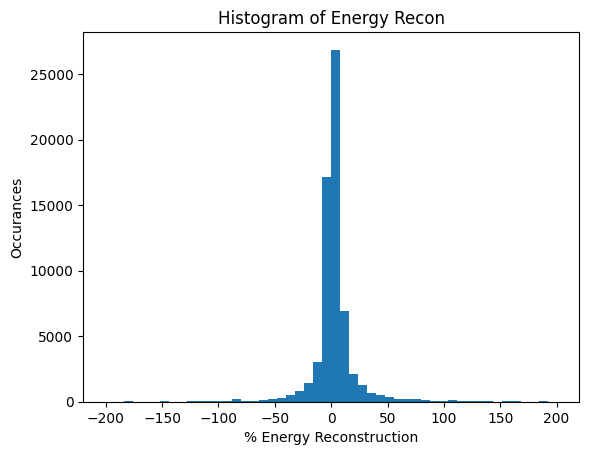

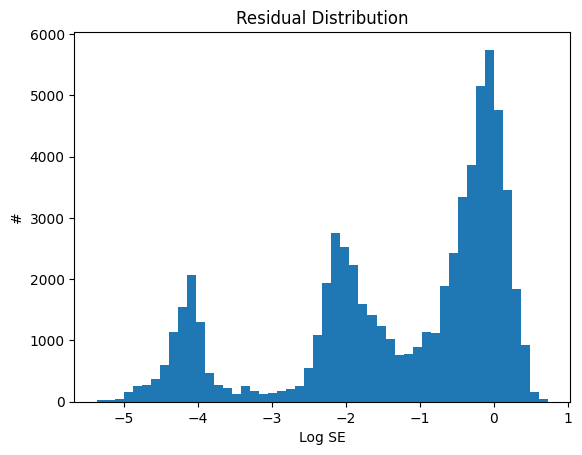

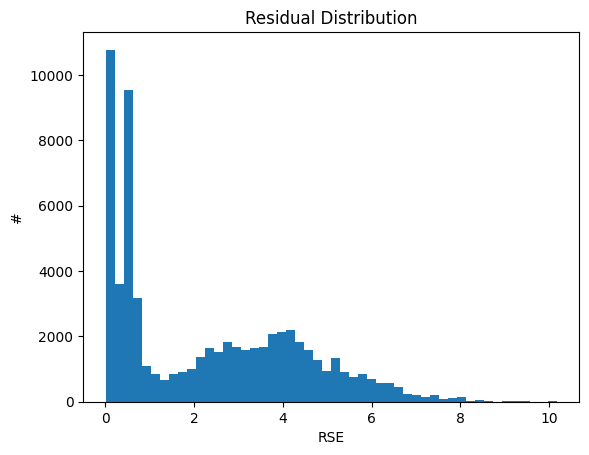

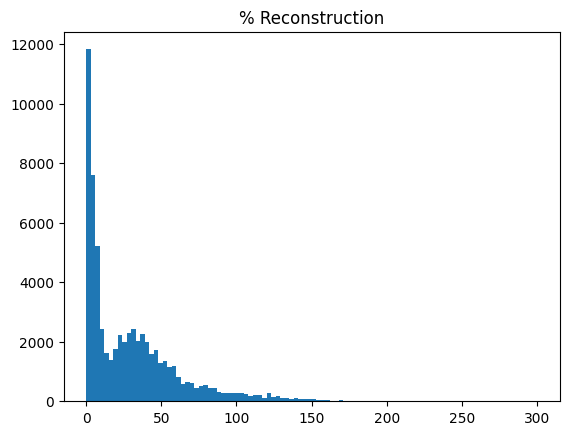

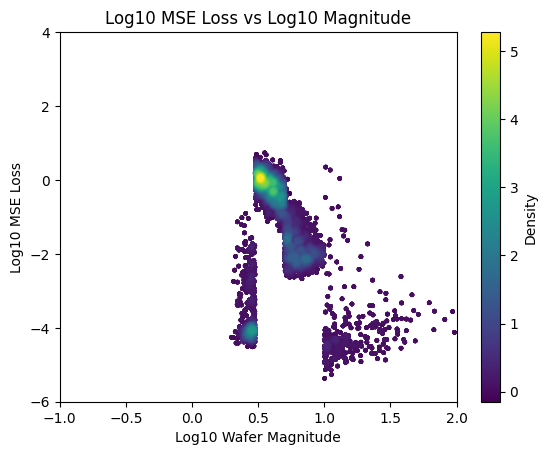

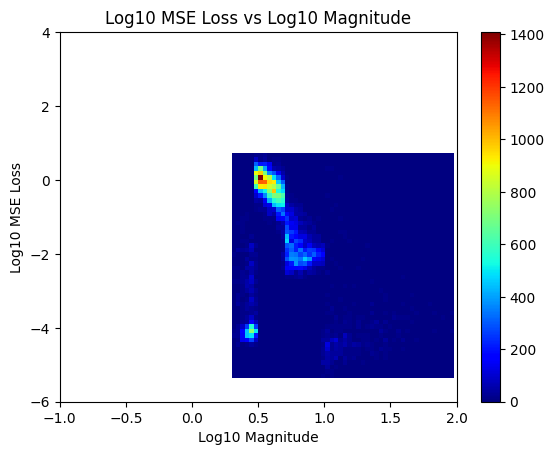

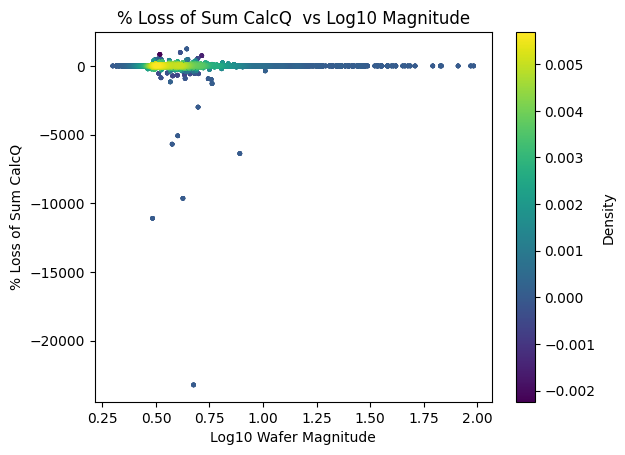

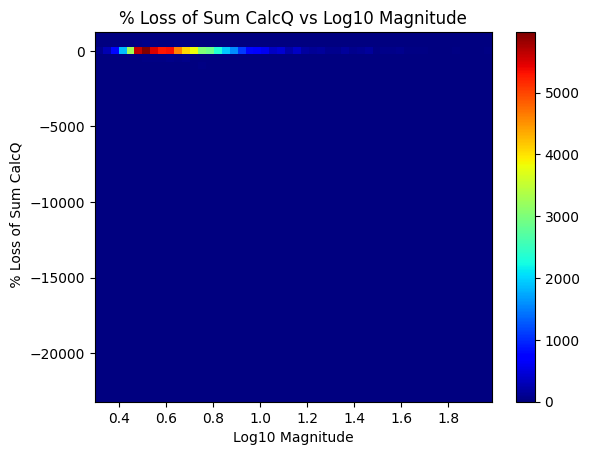

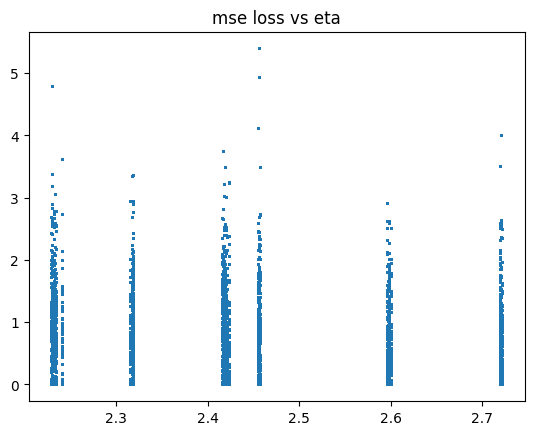

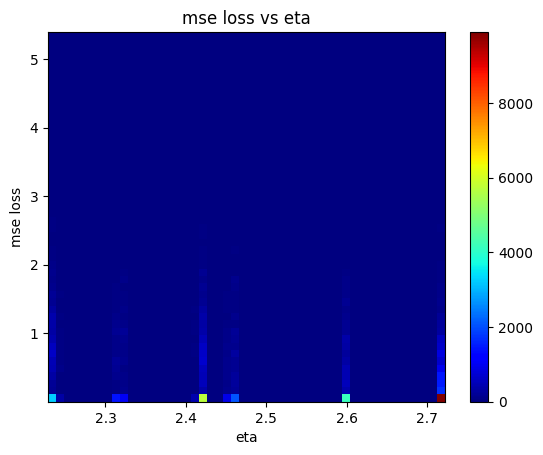

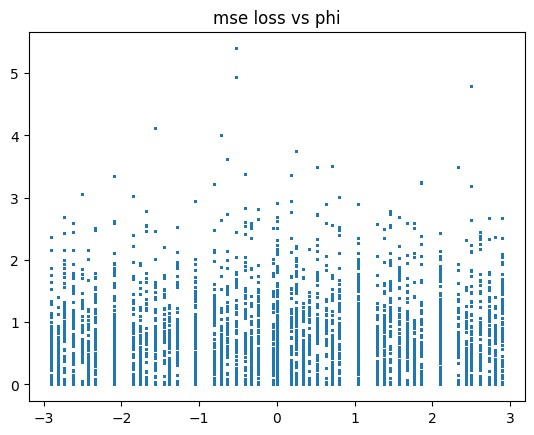

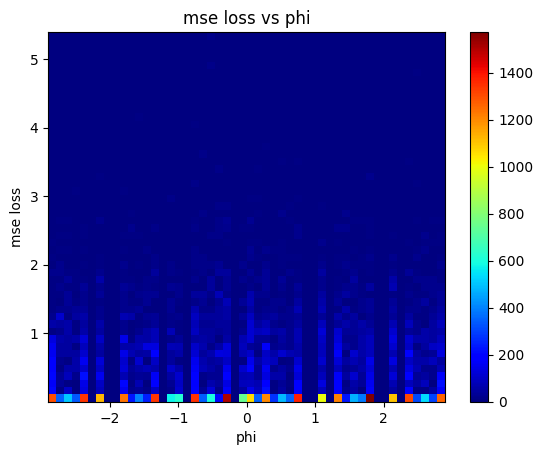

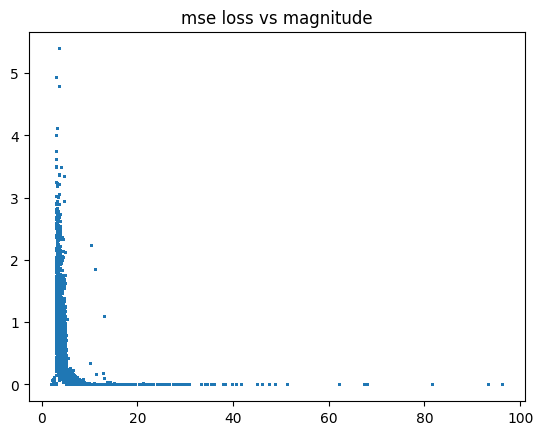

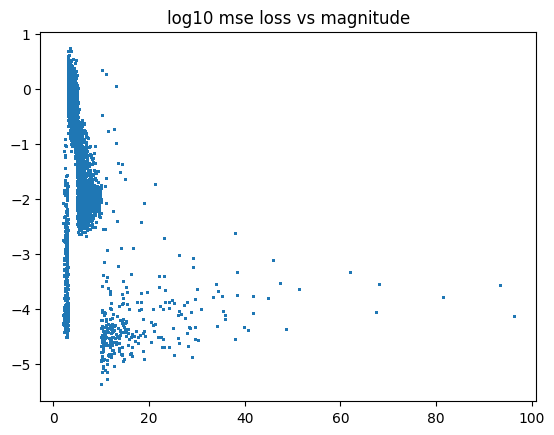

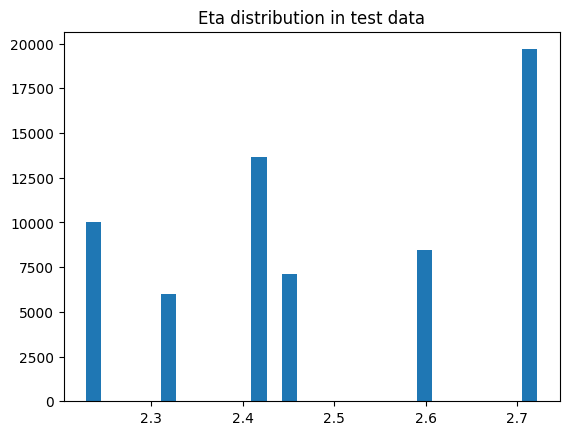

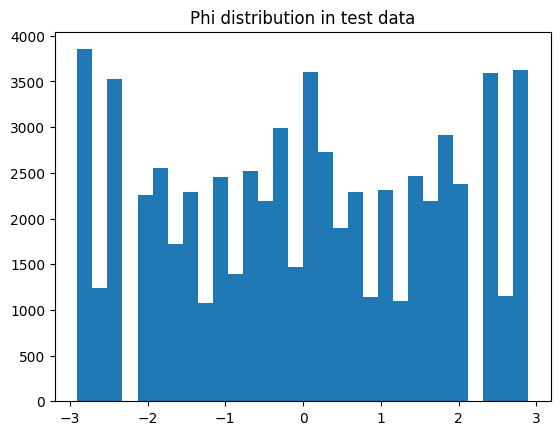

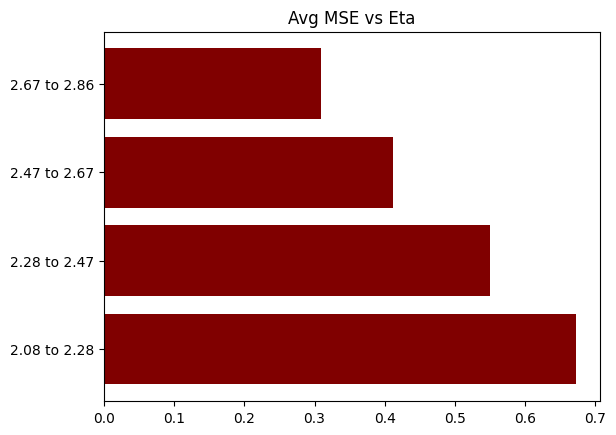

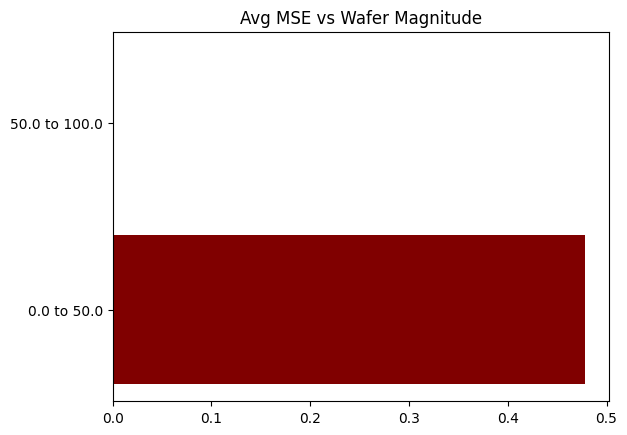

tensor([[ 2.3173e+00,  2.2389e-03,  1.0368e+01,  1.7589e-05,  2.1074e-02],
        [ 2.3173e+00,  2.2389e-03,  2.0993e+01,  4.0386e-05,  3.6161e-02],
        [ 2.3173e+00,  2.2389e-03,  8.1497e+01,  1.6793e-04,  6.8993e-02],
        ...,
        [ 2.2403e+00, -6.3815e-01,  2.9038e+00,  3.0671e-03,  1.0786e-01],
        [ 2.2403e+00, -6.3815e-01,  2.9869e+00,  5.8392e-04,  6.9294e-02],
        [ 2.2403e+00, -6.3815e-01,  2.9758e+00,  9.0363e-05,  5.0468e-02]],
       grad_fn=<CatBackward0>)

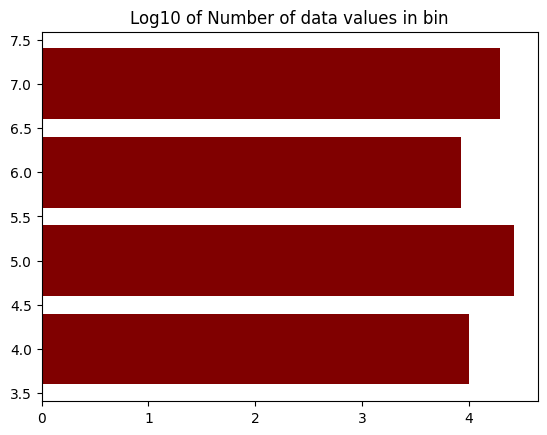

In [126]:
AE_Stats.gen_all_stats(pred,total_test[:,0:48],total_test)


In [129]:
torch.round((pred[0]*std+mean)).int()

tensor([  5,   8,   0,  57,  23,   5,  85,  72, 105,  14, 175,  38,   0,   0,
          0, 174,  15,  13,   0,   9,  13,  33,  40,  43,  11,  52,  48,   3,
         53, 339,   7,   8, 369,  79,   3,  39,   4,  32,  17,  13,  11,   6,
          0,   0,   0,   0,   0,  12], dtype=torch.int32)

In [130]:
(total_test[0,0:48]*std+mean).int()

tensor([  5,   8,   0,  57,  23,   5,  85,  72, 105,  14, 175,  38,   0,   0,
          0, 174,  15,  13,   0,   9,  13,  33,  40,  43,  11,  52,  48,   3,
         53, 339,   7,   8, 369,  79,   3,  39,   4,  32,  17,  13,  11,   6,
          0,   0,   0,   0,   0,  12], dtype=torch.int32)

In [145]:
truth = total_test[:,0:48]*std + mean

In [132]:
pred_norm = pred*std + mean

In [133]:
dif = truth[:,0:48]-pred_norm.detach()

In [48]:
sim_energy = total_test[:,-5]


In [69]:
layer = total_test[:,-8]

In [47]:
eta = total_test[:,-2]

(array([     0.,      0.,      0.,      0.,      0., 892079.,      0.,
             0.,      0.,      0.]),
 array([8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1, 9.2, 9.3, 9.4, 9.5]),
 <BarContainer object of 10 artists>)

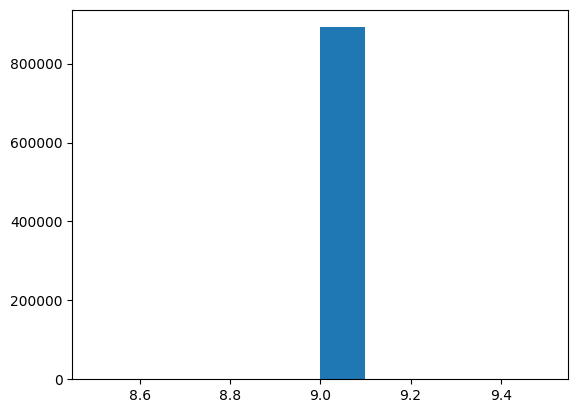

In [75]:
plt.hist(arr[:,-8])

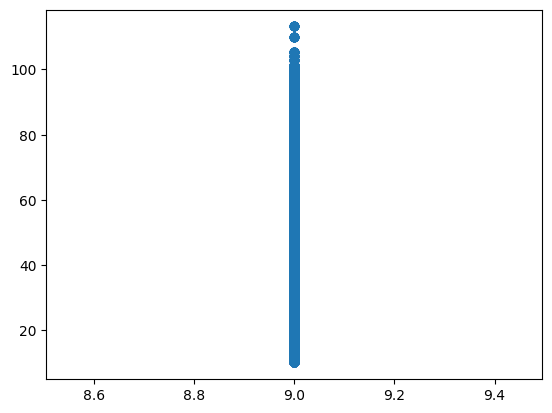

In [71]:
plt.scatter(layer,norms)

In [150]:
len(sim_energy)

64896

In [166]:
total_dif = torch.norm(dif.abs(),dim=1)

In [228]:
sum_dif = torch.sum(dif.abs(),dim=1)

In [232]:
sum_dif_no_abs = torch.sum(dif,dim=1)

In [167]:
truth_norm = torch.norm(truth,dim=1)

In [233]:
truth_sum_no_abs = torch.sum(truth,dim=1)

In [230]:
truth_sum = torch.sum(truth.abs(),dim=1)

In [ ]:
gen_n_batch_hist(truth_sum, 10, sum_dif, truth_sum,'Wafer % abs CaclQ Error from SUM CalcQ','CalcQ_Percent_Hist')

/tmp/ipykernel_216616/410788191.py:64: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return p[np.isfinite(p)]
/tmp/ipykernel_216616/410788191.py:51: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,10e4])


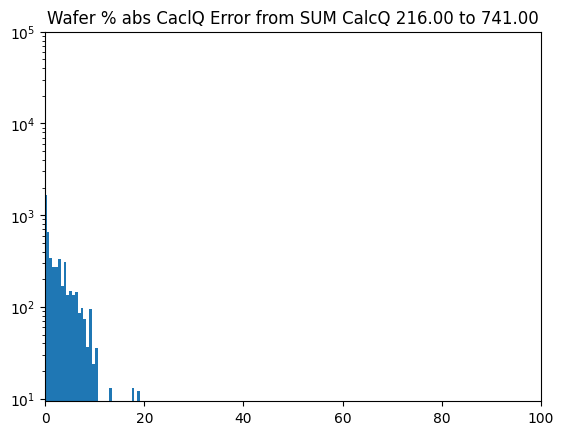

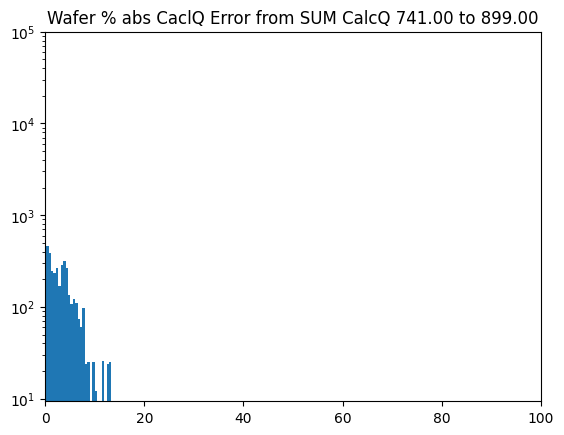

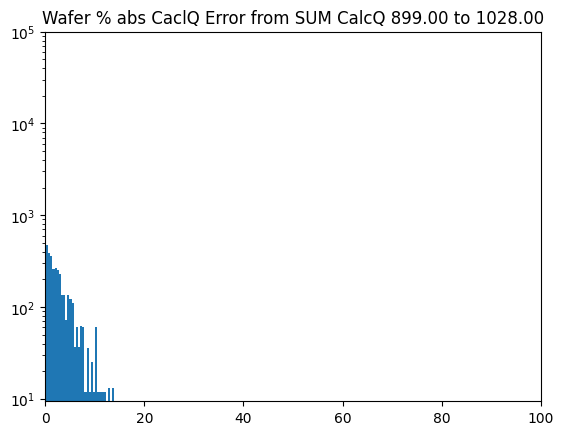

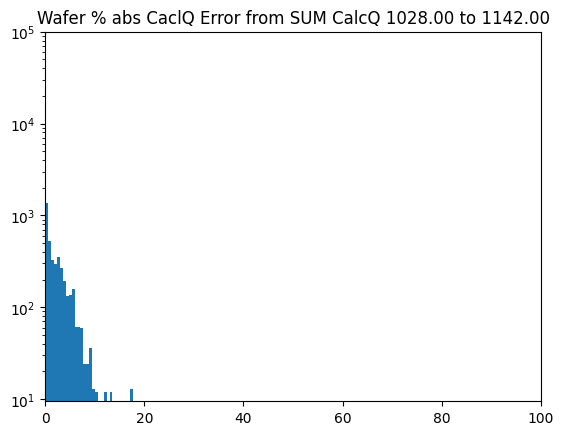

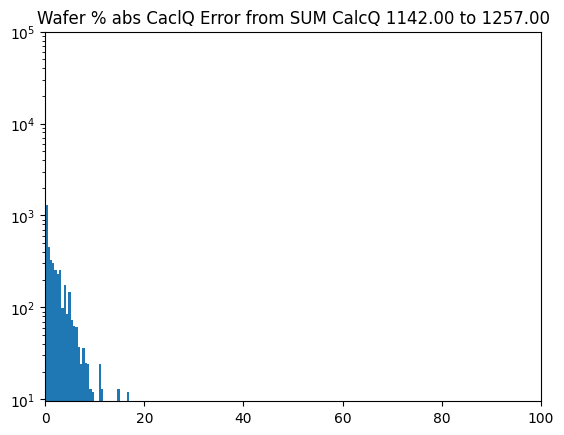

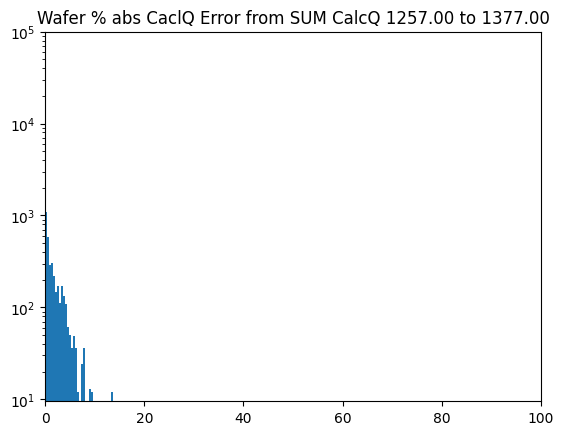

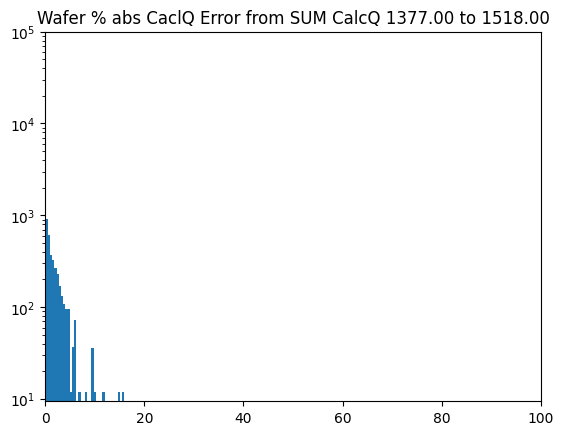

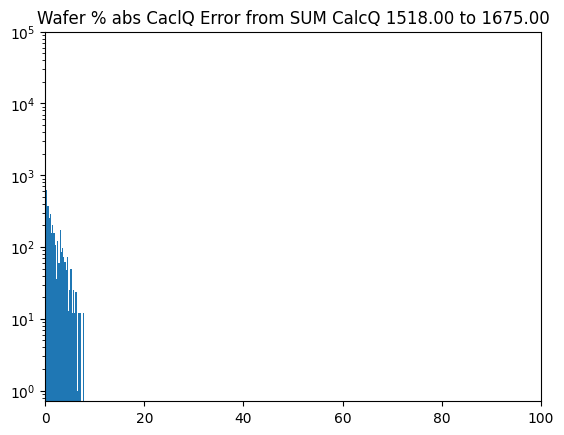

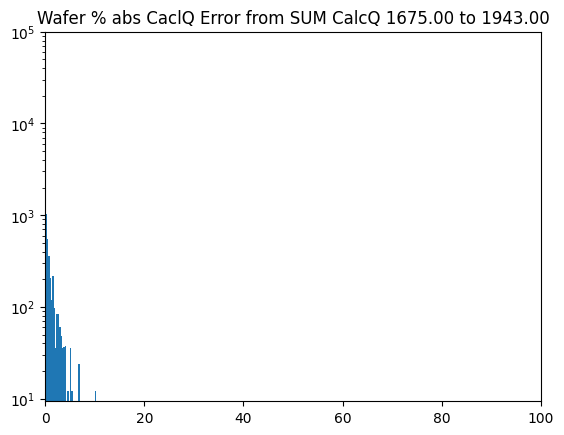

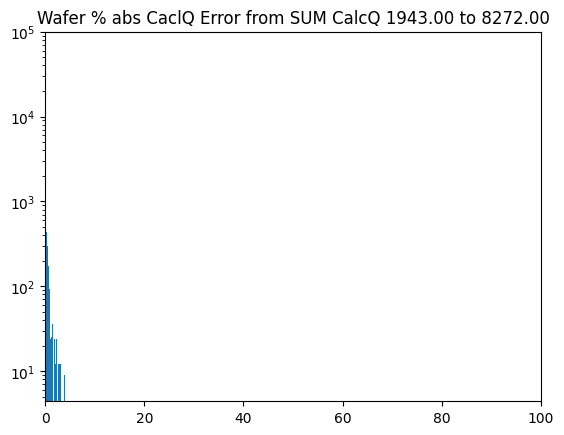

In [234]:
gen_n_batch_hist(truth_sum_no_abs, 10, sum_dif_no_abs, truth_sum_no_abs,'Wafer % abs CaclQ Error from SUM CalcQ','CalcQ_Percent_Hist')

In [212]:
truth_flat = torch.flatten(truth[:,0:48])
dif_flat = torch.flatten(dif)

/tmp/ipykernel_216616/410788191.py:64: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return p[np.isfinite(p)]
/tmp/ipykernel_216616/410788191.py:51: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,10e4])


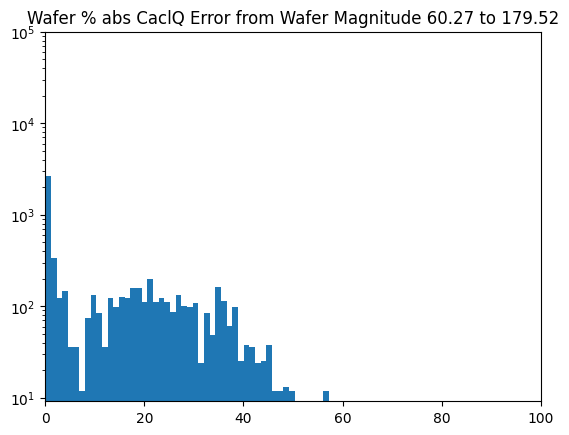

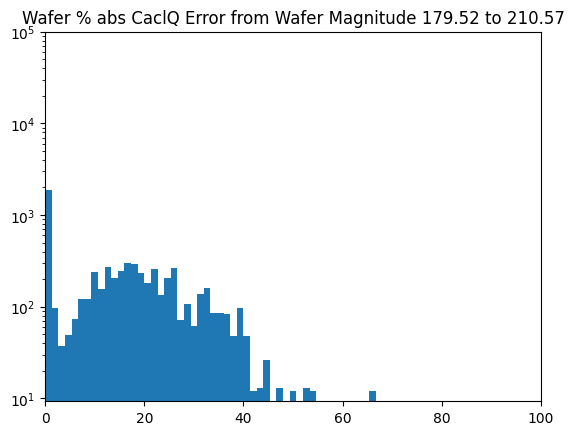

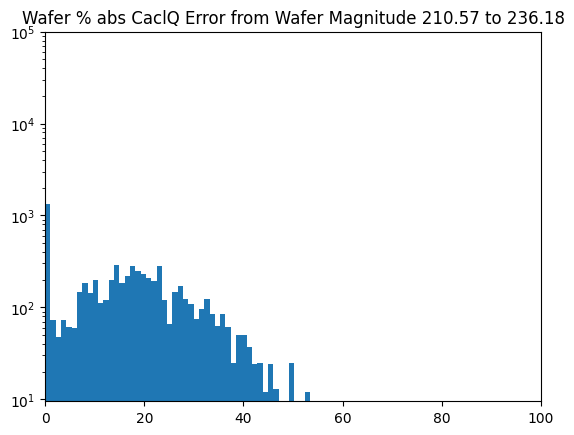

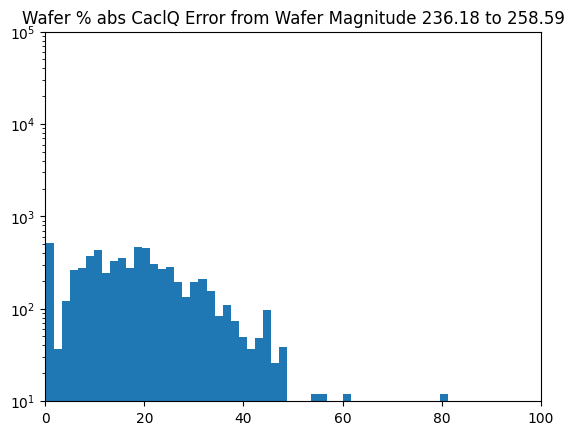

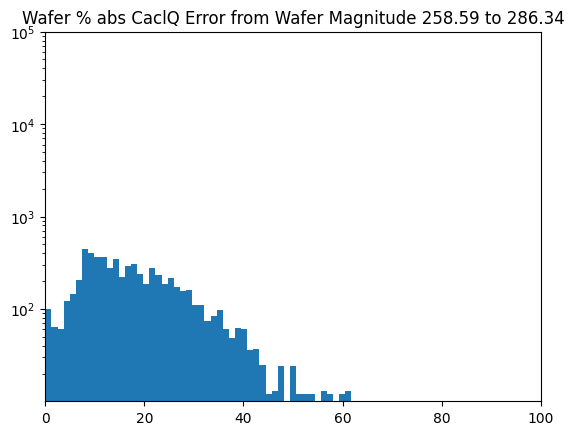

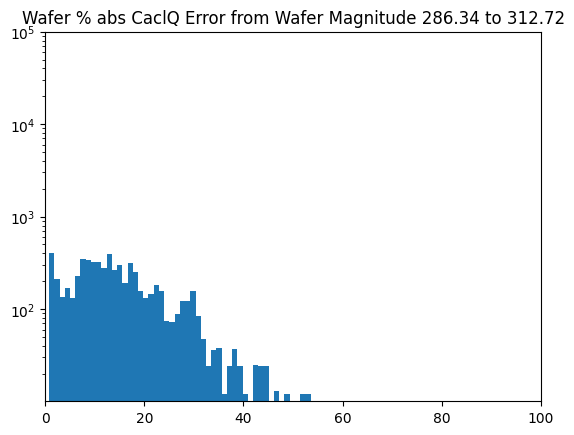

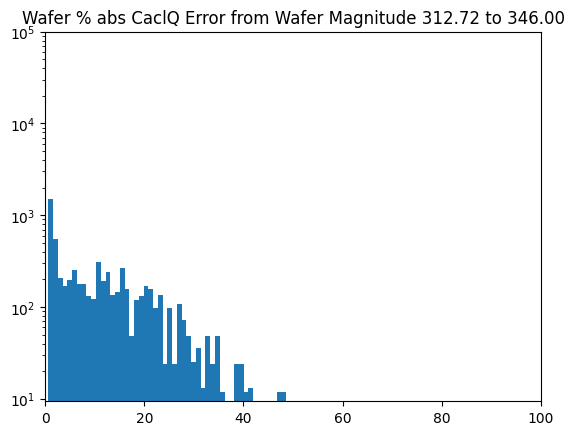

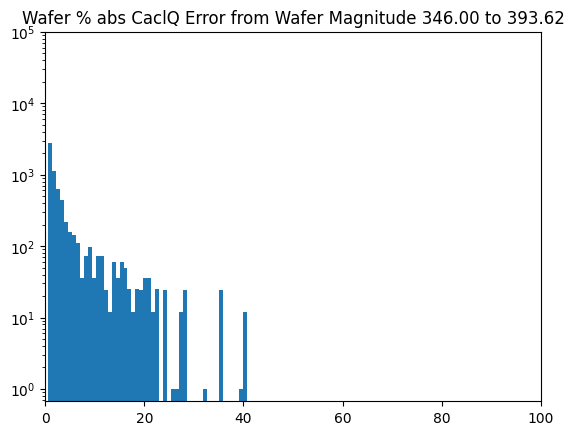

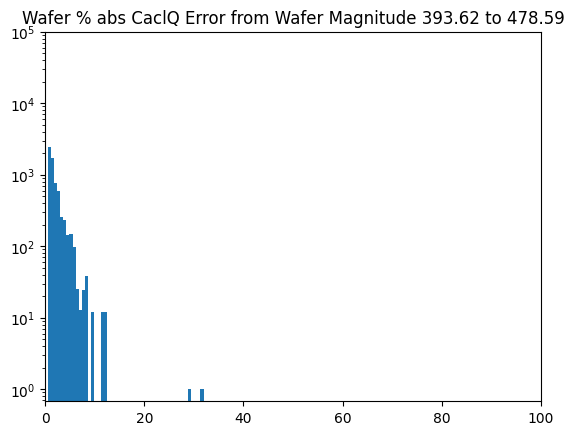

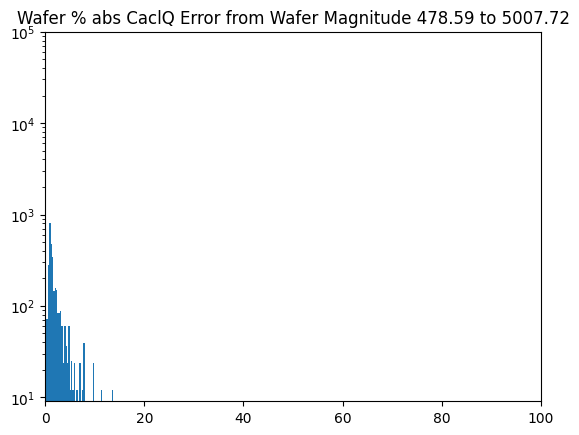

In [217]:
gen_n_batch_hist(truth_norm, 10, total_dif, truth_norm,'Wafer % abs CaclQ Error from Wafer Magnitude','CalcQ_Percent_Hist')

(array([2.0874e+04, 5.5660e+03, 2.4300e+03, 1.8880e+03, 2.3220e+03,
        2.2040e+03, 2.6340e+03, 2.2480e+03, 2.3390e+03, 2.4210e+03,
        2.2460e+03, 2.3190e+03, 1.9450e+03, 2.1190e+03, 1.5300e+03,
        1.3090e+03, 1.3530e+03, 1.0870e+03, 1.0100e+03, 8.5800e+02,
        7.1500e+02, 8.0900e+02, 5.1500e+02, 4.8600e+02, 4.1600e+02,
        2.8200e+02, 2.2100e+02, 2.0800e+02, 1.2700e+02, 1.1100e+02,
        8.5000e+01, 2.4000e+01, 4.9000e+01, 3.6000e+01, 2.5000e+01,
        2.4000e+01, 1.2000e+01, 1.2000e+01, 1.3000e+01, 0.0000e+00,
        0.0000e+00, 1.2000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2000e+01]),
 array([8.98398738e-03, 1.63186944e+00, 3.25475502e+00, 4.87764072e+00,
        6.50052595e+00, 8.12341118e+00, 9.74629688e+00, 1.13691826e+01,
        1.29920683e+01, 1.46149540e+01, 1.62378387e+01, 1.78607254e+01,
        1.94836102e+01, 2.11064949e+01, 2.27293816e+01, 2.43522663e+01,
        2.59751530e+01, 2.7598

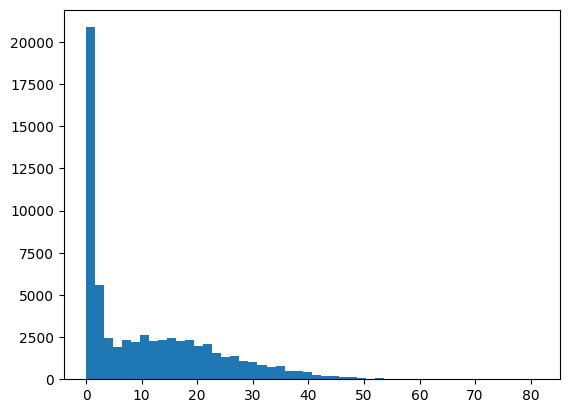

In [168]:
plt.hist(100*(total_dif/truth_norm).numpy(),bins = 50)

In [163]:
(total_dif/truth_norm).mean()

tensor(0.1131)

In [161]:
truth_norm[0]

tensor(603.1260)

In [219]:
truth_flat[0:10]

tensor([  5.,   8.,   0.,  57.,  23.,   5.,  85.,  72., 105.,  14.])

In [220]:
dif_flat[0:10]

tensor([-0.0035, -0.0045,  0.0261,  0.0269,  0.0550,  0.0296,  0.0839,  0.0365,
         0.0428,  0.0202])

In [223]:
len(truth_flat[0:10000])

10000

/tmp/ipykernel_216616/410788191.py:64: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return p[np.isfinite(p)]
/tmp/ipykernel_216616/410788191.py:50: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xlim([0,100])
/tmp/ipykernel_216616/410788191.py:51: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,10e4])


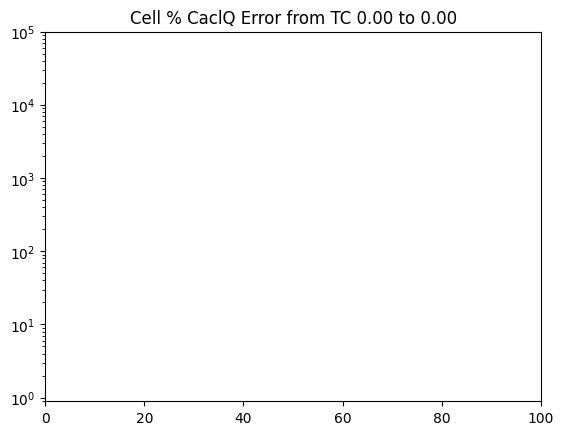

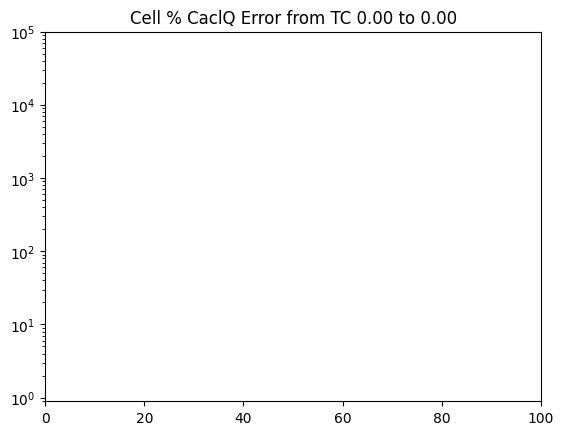

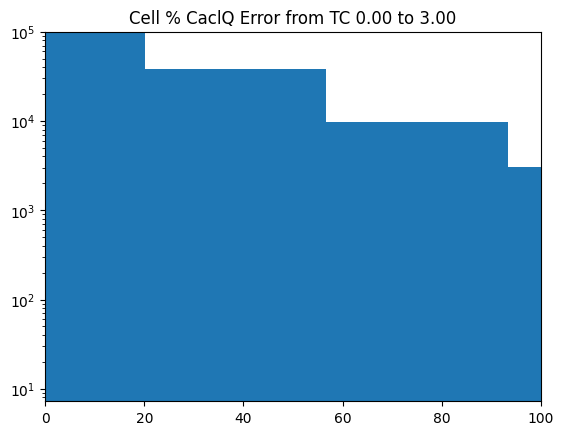

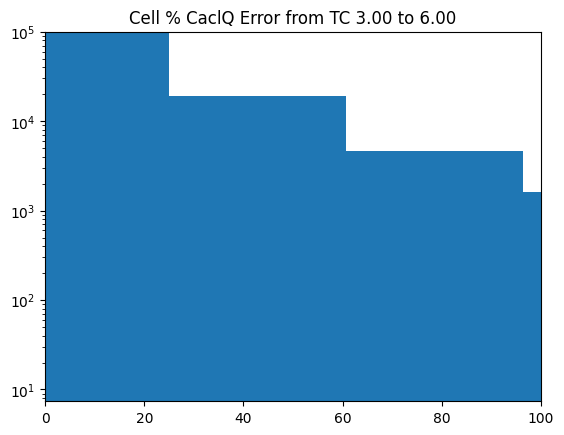

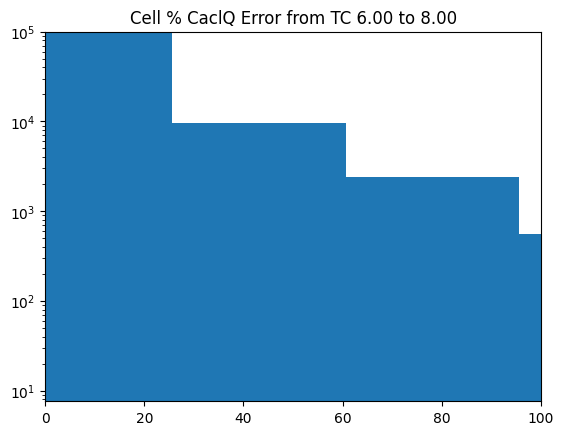

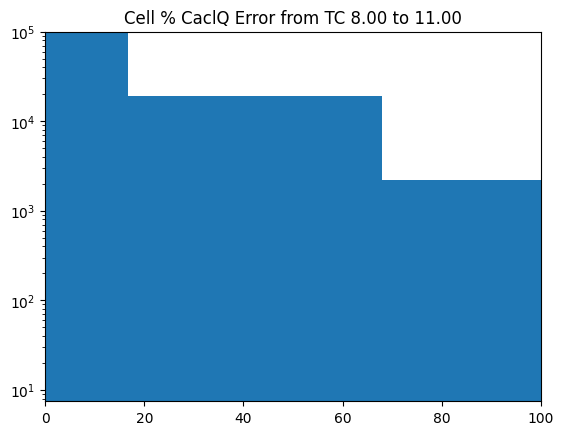

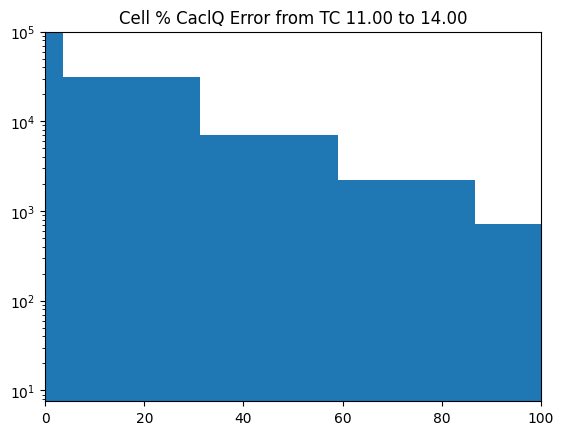

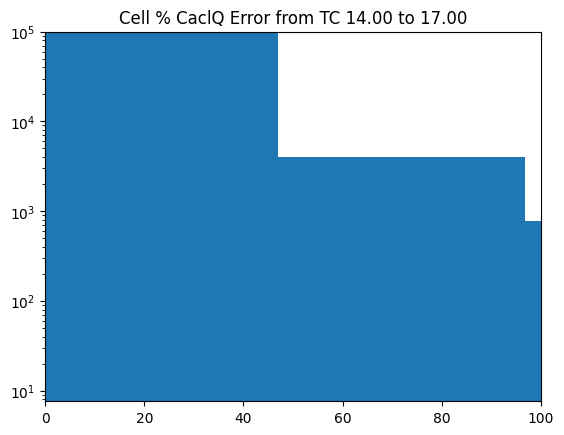

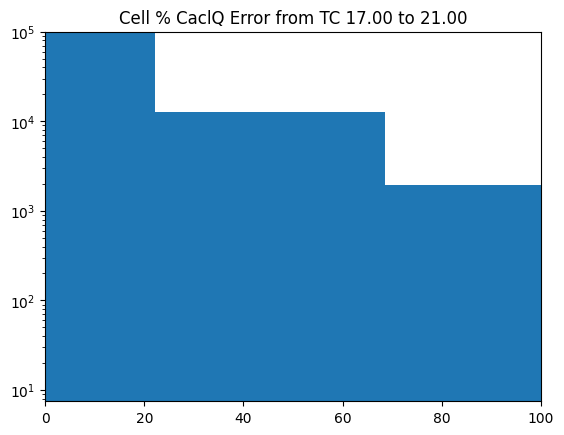

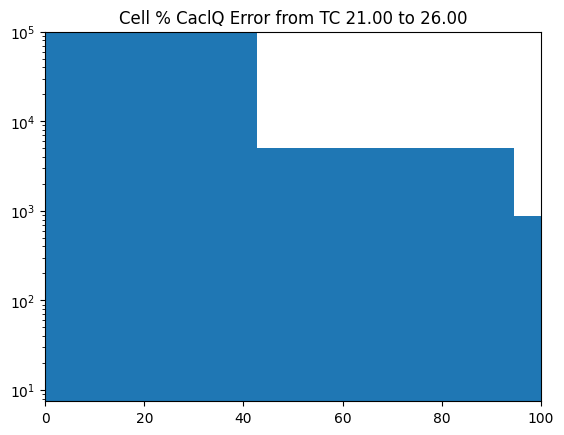

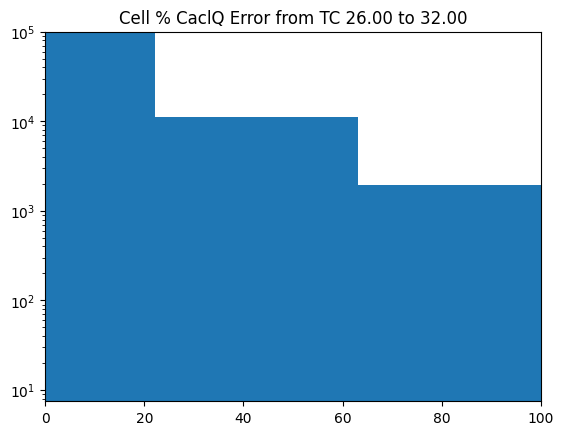

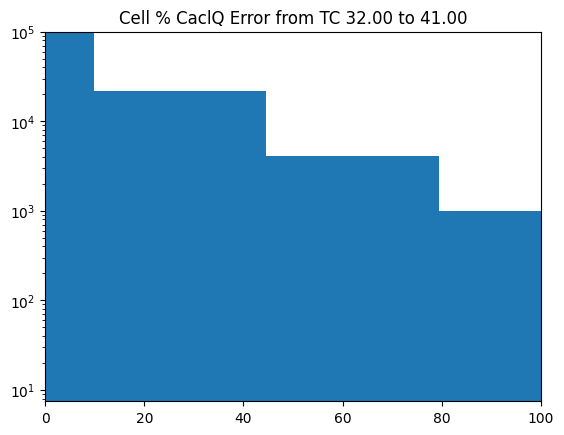

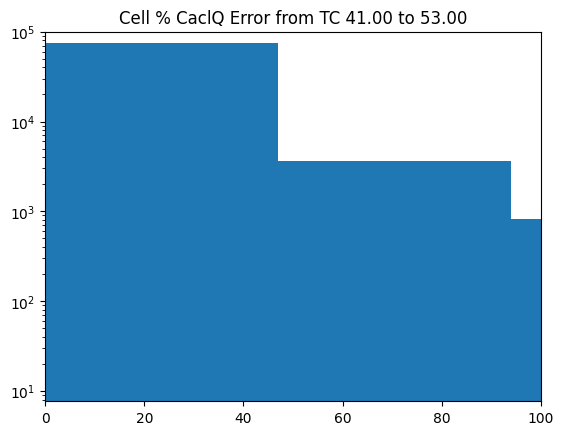

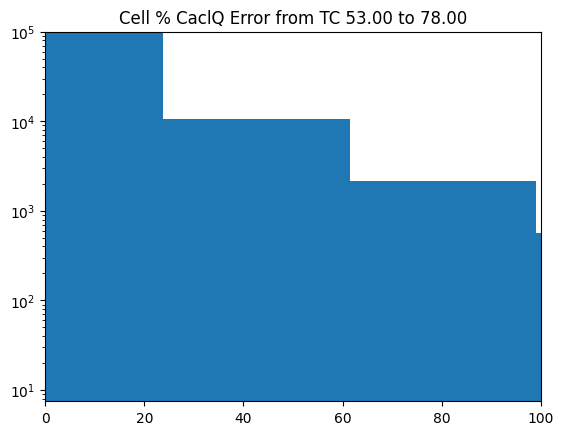

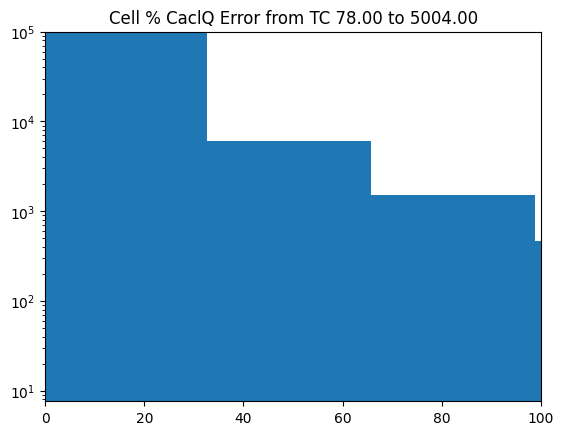

In [218]:
gen_n_batch_hist(truth_flat, 15, dif_flat , truth_flat,'Cell % CaclQ Error from TC','CalcQ_Percent_Hist')

/tmp/ipykernel_216616/410788191.py:64: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return p[np.isfinite(p)]
/tmp/ipykernel_216616/410788191.py:51: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,10e4])


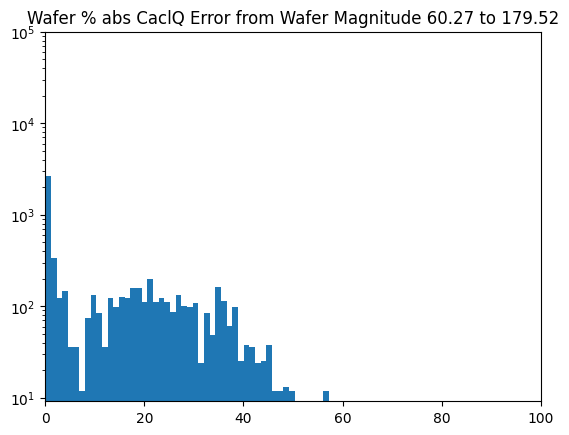

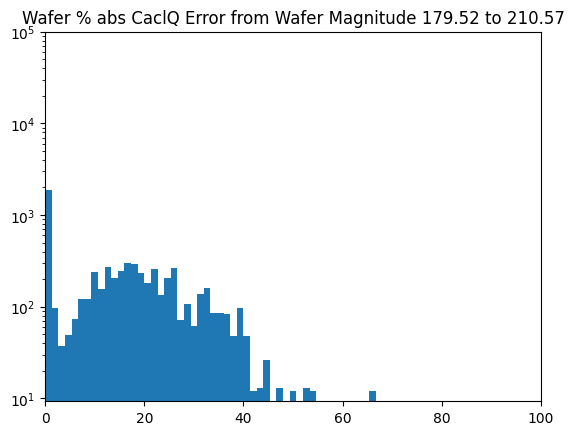

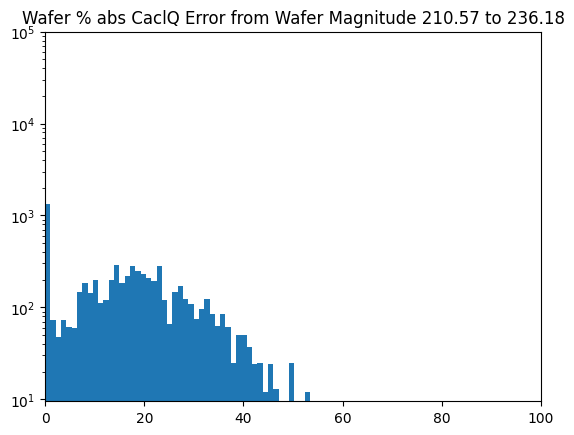

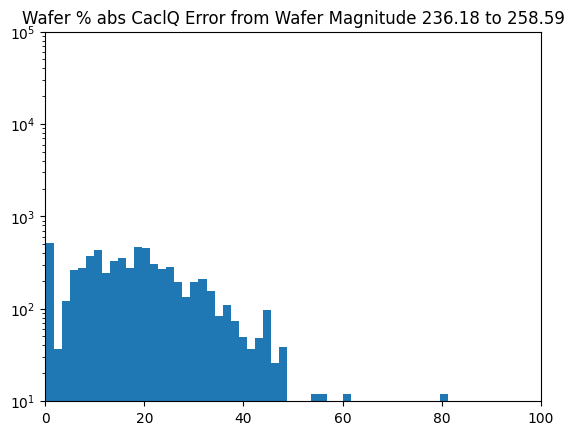

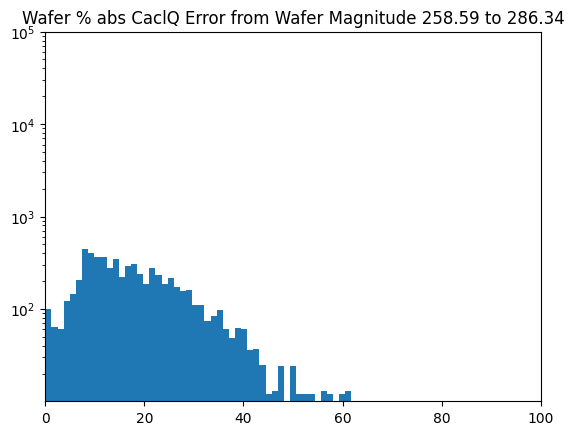

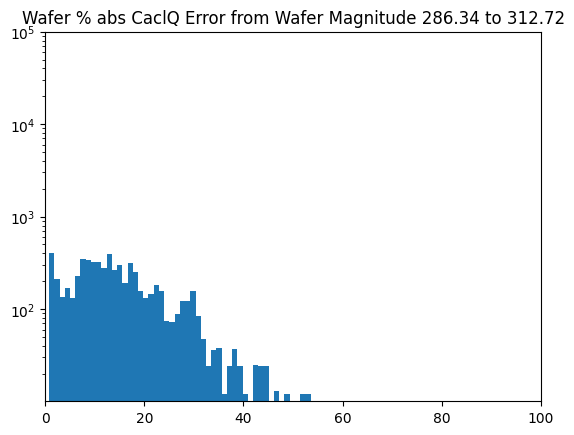

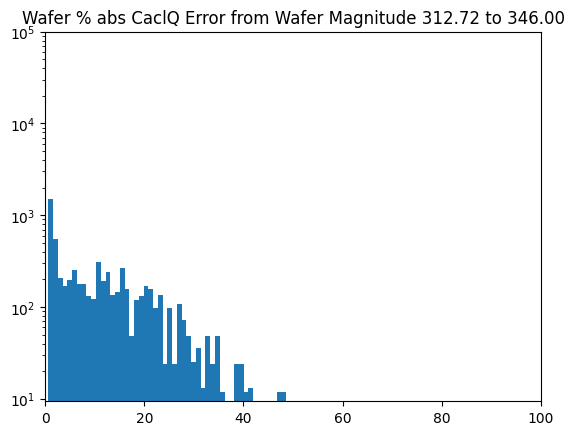

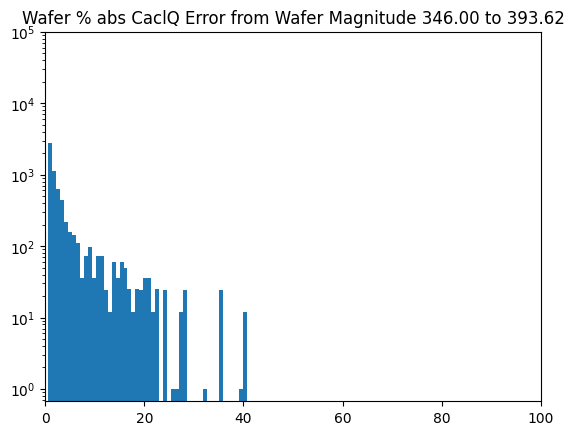

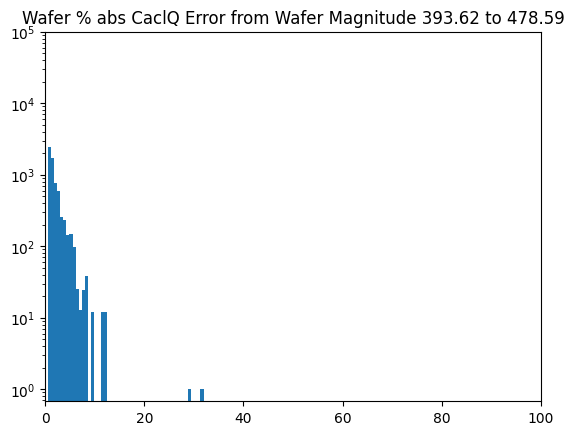

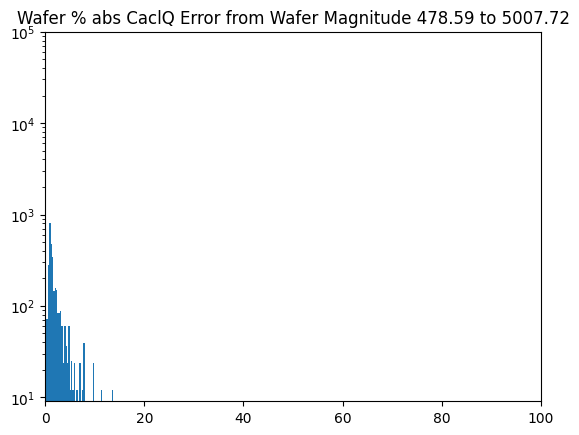

In [217]:
gen_n_batch_hist(truth_norm, 10, total_dif, truth_norm,'Wafer % abs CaclQ Error from Wafer Magnitude','CalcQ_Percent_Hist')

/tmp/ipykernel_216616/2432979565.py:62: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return p[np.isfinite(p)]


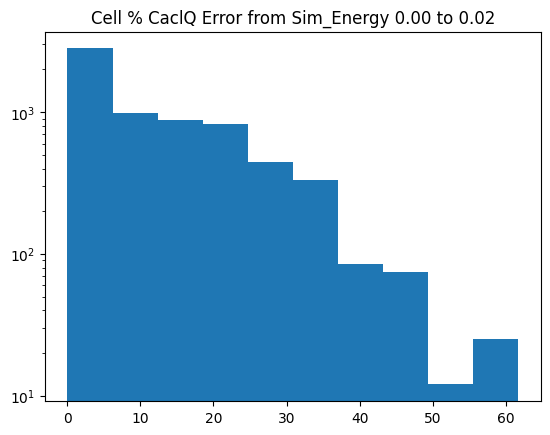

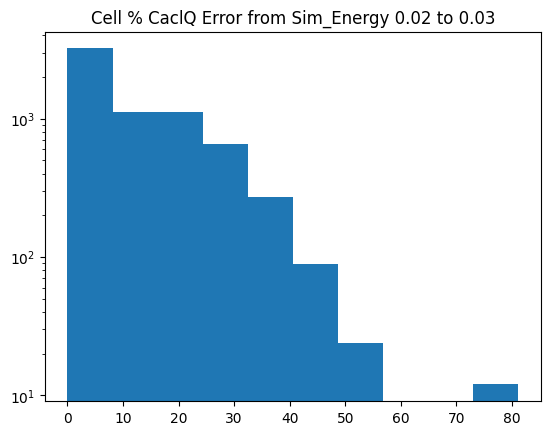

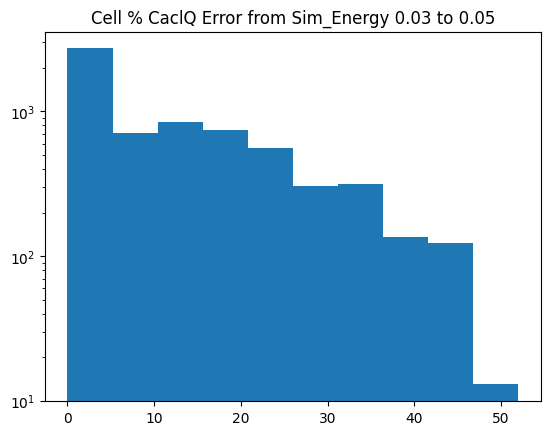

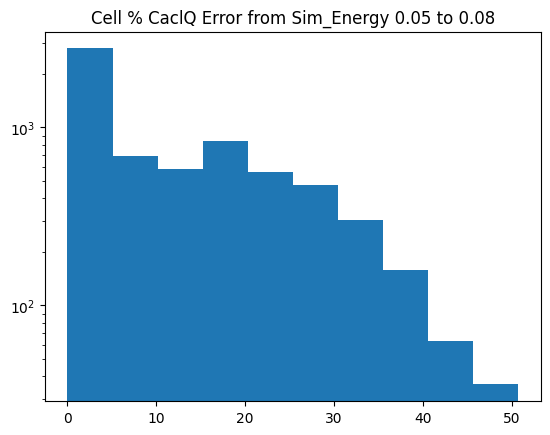

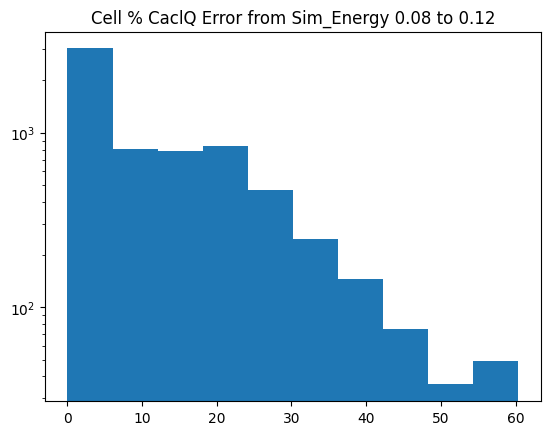

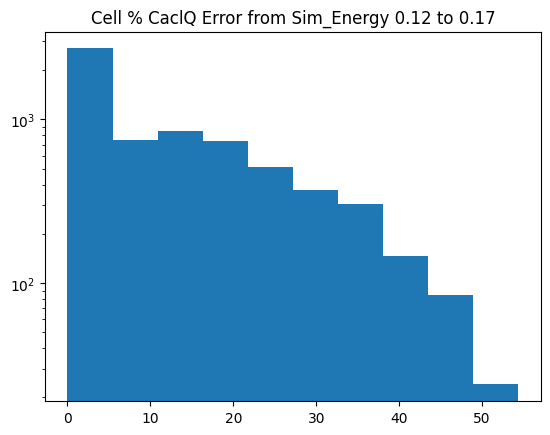

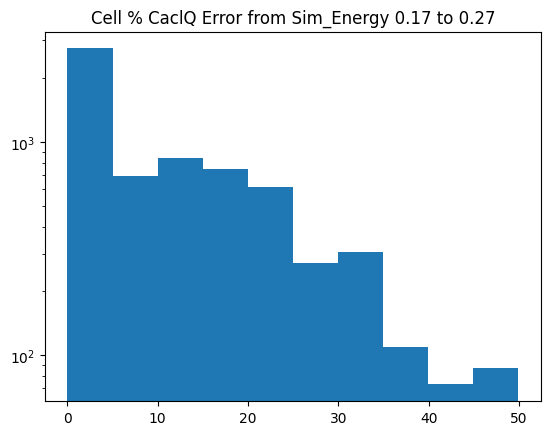

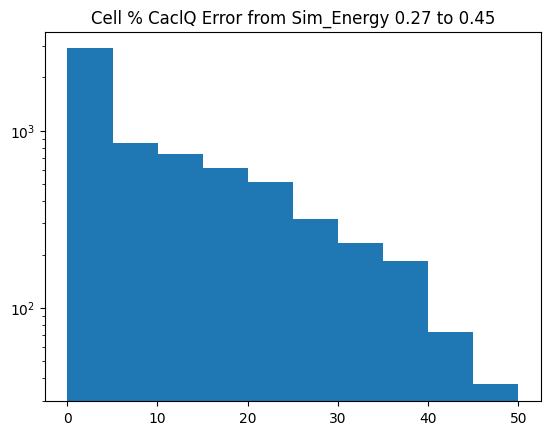

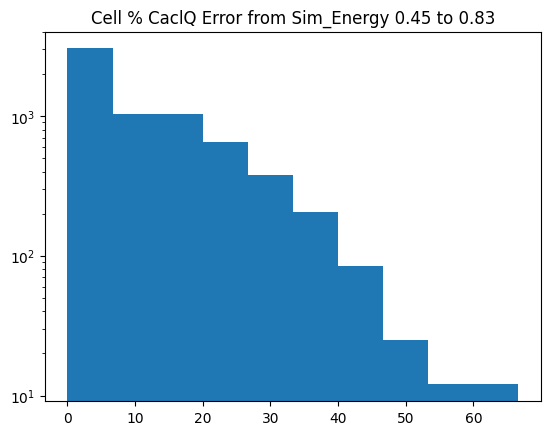

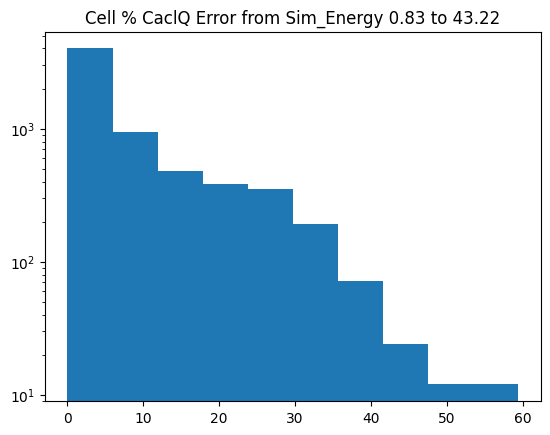

In [203]:
gen_n_batch_hist(sim_energy, 10, total_dif, truth_norm,'Cell % CaclQ Error from Sim_Energy','CalcQ_Percent_Hist')

In [105]:
int_pred = torch.round(pred*std + mean)

In [106]:
norm_truth = total_test*std + mean

/tmp/ipykernel_216616/410788191.py:64: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return p[np.isfinite(p)]
/tmp/ipykernel_216616/410788191.py:51: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,10e4])


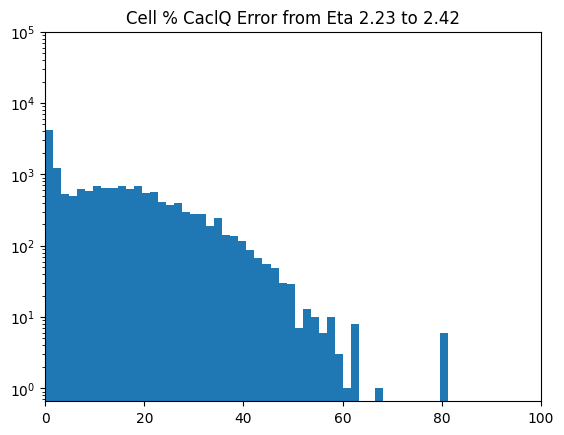

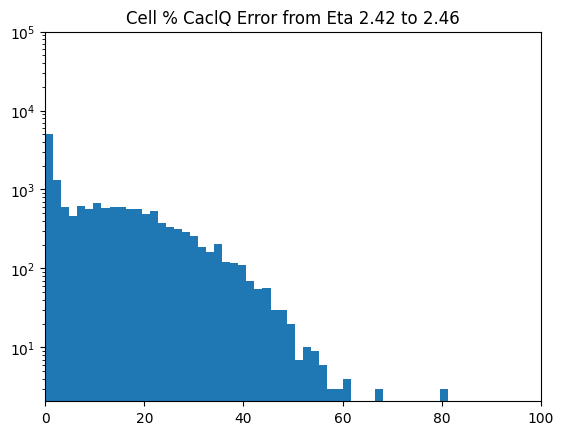

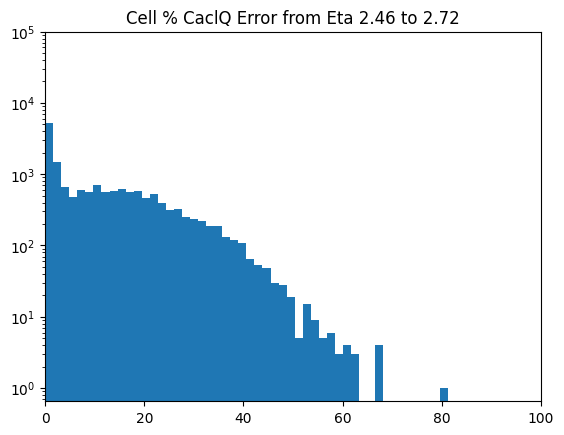

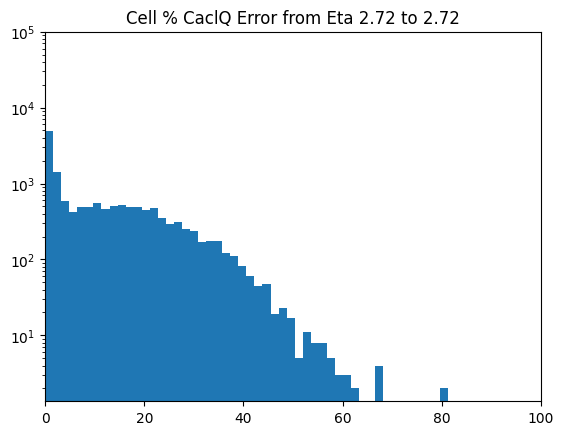

In [226]:
gen_n_batch_hist(eta, 4, total_dif, truth_norm,'Cell % CaclQ Error from Eta','CalcQ_Percent_Hist')

In [224]:
np.linspace(0,100,5+1)

array([  0.,  20.,  40.,  60.,  80., 100.])

In [225]:
eta.min()

tensor(2.2287)

In [194]:
np.percentile(eta, np.linspace(0,100,5)[1:])

array([2.41610241, 2.45570707, 2.71969008, 2.7220335 ])